In [376]:
import requests
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import json
import math

In [6]:
import glob
onlyfiles = glob.glob("/home/bartuka/HackinSampa2017/data/transparencia/*.xls")

In [7]:
dfs = []
for file_ in onlyfiles:
    print("Reading file {}".format(file_))
    df = pd.read_excel(file_, skip_lines=1)
    dfs.append(df)
df = pd.concat(dfs)
print(df.shape)    

Reading file /home/bartuka/HackinSampa2017/data/transparencia/Extrato de Contrato - Janeiro_2011 a Dezembro_2015.xls
Reading file /home/bartuka/HackinSampa2017/data/transparencia/Extrato de Contrato - Janeiro_2016 a Fevereiro_2017.xls
Reading file /home/bartuka/HackinSampa2017/data/transparencia/Extrato de Contrato - Janeiro_2005 a Dezembro_2010.xls
(83574, 17)


In [134]:
df.head()

,Orgão,Retranca,Modalidade,Número Licitação,Número Processo,Evento,objeto,Data Publicação Extrato,Fornecedor,Fornecedor Tipo,Fornecedor Documento,Data Assinatura Extrato,Validade Extrato,Tipo Validade Extrato,Valor Contrato,Unnamed: 15,Número Contrato
50,EDUCAÇÃO,EGIAADM,PREGÃO PRESENCIAL,2011-0.236.089-5,2011-0.236.089-5,EXTRATO DE CONTRATO,CONTRATAÇÃO DE EMPRESA ESPECIALIZADA EM PRESTA...,12/10/2011,COOPERPLANALTO – COOPERATIVA DE TRABALHO EM TR...,PJ,8.711644e+12,05/10/2011,30.0,Meses,131067.9,NaN,14/DRE IP/2011
51,EDUCAÇÃO,EGIAADM,PREGÃO PRESENCIAL,2011-0.213.504-2,2011-0.213.504-2,EXTRATO DE CONTRATO,AQUISIÇÃO E INSTALAÇÃO DE EQUIPAMENTOS DE SOM ...,12/10/2011,PROVISÃO JC COMÉRCIO DE ELETRO ELETRÔNICOS LTD...,PJ,1.028450e+13,10/10/2011,30.0,Dias,56900.0,NaN,15/DRE IP/2011
71,EDUCAÇÃO,EGAAADM,PREGÃO PRESENCIAL,25/SME/2011,2011-0.118.459-7,EXTRATO DE CONTRATO,AQUISIÇÃO DE SOLUÇÃO DE ARMAZENAGEM COM BACKUP...,12/10/2011,F9C SECURITY LTDA,PJ,3.822315e+12,11/10/2011,36.0,Meses,3750000.0,NaN,129/SME/2011
87,EDUCAÇÃO,EGAAADM,PREGÃO PRESENCIAL,13/SME/2011,2011-0.071.883-0,EXTRATO DE ATA DE REGISTRO DE PREÇO,ATA DE REGISTRO DE PREÇOS PARA AQUISIÇÃO DE ...,14/10/2011,LEVIN COMERCIAL LTDA ME,PJ,9.127785e+12,13/10/2011,12.0,Meses,336.9,NaN,12/SME/2011
136,EDUCAÇÃO,EGAAADM,PREGÃO PRESENCIAL,12/SME/2011,2011-0.041.857-8,EXTRATO DE CONTRATO,ATA DE RP - AQUISIÇÃO DE MOBILIARIO ESCOLAR: A...,14/10/2011,W3 INDÚSTRIAS METALÚRGICAS LTDA,PF,8.111480e+13,13/10/2011,60.0,Dias,459720.0,NaN,151/SME/2011


In [10]:
pregoes = ["PREGÃO PRESENCIAL", "PREGÃO", "PREGÃO ELETRÔNICO"]

In [15]:
df = df[(df["Modalidade"].isin(pregoes)) & (df['Orgão'] == "EDUCAÇÃO")]
len(df)

2629

In [17]:
num_processes = df['Número Processo'].unique()
num_processes

array(['2011-0.236.089-5    ', '2011-0.213.504-2    ',
       '2011-0.118.459-7    ', '2011-0.071.883-0    ',
       '2011-0.041.857-8    ', '2010-0.130.314-4    ',
       '200900548130        ', '2007-0.235.572-7    ',
       '2010-0.296.316-4    ', '2011-0.079.506-1    ',
       '2011-0.122.699-0    ', '2011-0.093.874-1    ',
       '2008-0.142.503-0    ', '2008-0.0142.512-0   ',
       '200802681065        ', '2007-0.308.332-1    ',
       '2010-0.208.514-0    ', '2011-0.213851-3     ',
       '201001333078        ', '201000027070        ',
       '2006-0.190.898-4    ', '2008-0.375.915-7    ',
       '2010-0.289.120-1    ', '2010-0.216.562-4    ',
       '2011-0.290.383-0    ', '2007-0.237.587-8    ',
       '2009-0.201.334-0    ', '2010-0.096.256-0    ',
       '2008-0.250.905-0    ', '2011-0.156.859-0    ',
       '2011-0.015.986-6    ', '2005-0.225.939-2    ',
       '2007-0.128.163-0    ', '2011-0.169.205-3    ',
       '2009-0.298.281-4    ', '2011-0.112.244-3    ',
       '20

In [20]:
url_base = "http://devcolab.each.usp.br/do/"
list_urls = []
process_url_dict = {}
for num_process in tqdm(num_processes):
    list_urls = []
    num_process = num_process.strip()
    url_educacao = "http://devcolab.each.usp.br/do/?utf8=%E2%9C%93&q={}+dota%C3%A7%C3%A3o".format(num_process)
    resp = requests.get(url_educacao)

    if resp.status_code == 200:
        soup = BeautifulSoup(resp.text, "lxml")
        for a in soup.find_all('a', href=True):
            regexp = re.match("(?P<year>[0-9]{4}\/)", a["href"])
            if regexp:
                url_new = url_base + a["href"] + ".json"
                list_urls.append(url_new)

    process_url_dict[num_process] = list_urls

100%|██████████| 642/642 [11:35<00:00,  1.01it/s] 


## Projeto xupinhada

In [359]:
url_base = "http://devcolab.each.usp.br/do/"
list_urls = []
process_url_dict = {}
list_urls = []

for i in tqdm(range(1, 500)):

    num_process = num_process.strip()
    url_educacao = "http://devcolab.each.usp.br/do/?utf8=%E2%9C%93&f%5Bsecretaria_facet%5D%5B%5D=EDUCA%C3%87%C3%83O&f%5Btipo_conteudo_facet%5D%5B%5D=LICITA%C3%87%C3%95ES&q=homolog*&pages={}".format(i)
    #url_educacao = "http://devcolab.each.usp.br/do/?utf8=%E2%9C%93&q=16.12.12.122.3024.2.100.3.3.90.30.00.00+homolog*&pages={}".format(i)
    resp = requests.get(url_educacao)

    if resp.status_code == 200:
        soup = BeautifulSoup(resp.text, "lxml")
        for a in soup.find_all('a', href=True):
            regexp = re.match("(?P<year>[0-9]{4}\/)", a["href"])
            if regexp:
                url_new = url_base + a["href"] + ".json"
                list_urls.append(url_new)

    process_url_dict[num_process] = list_urls

100%|██████████| 499/499 [03:17<00:00,  1.85it/s]


In [360]:
process_url_dict

{'2010-0.217.306-6': ['http://devcolab.each.usp.br/do/2017/06/01/19.json',
  'http://devcolab.each.usp.br/do/2017/06/01/20.json',
  'http://devcolab.each.usp.br/do/2017/06/01/431.json',
  'http://devcolab.each.usp.br/do/2017/05/28/30.json',
  'http://devcolab.each.usp.br/do/2017/05/21/846.json',
  'http://devcolab.each.usp.br/do/2017/05/19/27.json',
  'http://devcolab.each.usp.br/do/2017/05/19/28.json',
  'http://devcolab.each.usp.br/do/2017/05/18/539.json',
  'http://devcolab.each.usp.br/do/2017/05/17/332.json',
  'http://devcolab.each.usp.br/do/2017/05/11/41.json',
  'http://devcolab.each.usp.br/do/2017/06/01/19.json',
  'http://devcolab.each.usp.br/do/2017/06/01/20.json',
  'http://devcolab.each.usp.br/do/2017/06/01/431.json',
  'http://devcolab.each.usp.br/do/2017/05/28/30.json',
  'http://devcolab.each.usp.br/do/2017/05/21/846.json',
  'http://devcolab.each.usp.br/do/2017/05/19/27.json',
  'http://devcolab.each.usp.br/do/2017/05/19/28.json',
  'http://devcolab.each.usp.br/do/2017/

In [362]:
list_links = process_url_dict['2010-0.217.306-6']

In [363]:
list_dotacao = []
list_dates = []
for el in tqdm(list_links):
    try:
        resp = requests.get(el)

        if resp.status_code == 200:
            rxp = re.findall("(?P<moneys>R\$.*?\s)", resp.json()["response"]["texto"])
            rxp2 = re.findall("(?P<moneys>R\$ .*?\s)", resp.json()["response"]["texto"])
            moneys = [el.split("R$")[1].strip() for el in rxp]
            moneys2 = [el.split("R$")[1].strip() for el in rxp2]
            moneys += moneys2

        list_moneys = []
        for money in moneys:
            if money != '':
                valor = float(money.replace(",", "").replace(".", "")) / 100
                list_moneys.append(valor)
        list_dotacao.append(max(list_moneys))
        list_dates.append(resp.json()["response"]["data"])
    except:
        pass

100%|██████████| 4990/4990 [04:50<00:00, 26.96it/s]


In [364]:
list_dotacao

[49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 10986.3,
 43330.0,
 795.0,
 87425.0,
 49979000.0,
 75000000.0,
 4953.8,
 32132.25,
 12600.0,
 109

In [365]:
from datetime import datetime
import dateutil

datas = [dateutil.parser.parse(el).date() for el in list_dates]
df = pd.DataFrame({"datas": datas, "valores": list_dotacao})
df.set_index("datas", inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [366]:
df

,valores
datas,
2017-05-11,87425.0
2017-05-11,87425.0
2017-05-11,87425.0
2017-05-11,87425.0
2017-05-11,87425.0
2017-05-11,87425.0
2017-05-11,87425.0
2017-05-11,87425.0
2017-05-11,87425.0


In [370]:
detalhes = [{"data": "{}-{}-{}".format(key.date().year, key.date().month, key.date().day), "valor": value["valores"]} for key, value in df.iterrows()]

In [368]:
detalhes

[{'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87425.0},
 {'data': '2017-5-11', 'valor': 87

In [369]:
df = df.drop_duplicates()

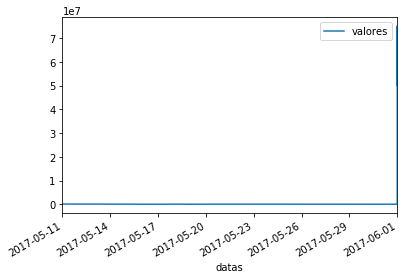

In [371]:
df.plot()
plt.show()

In [373]:
{"titulo": "AUTORIZO",
 "orgao": "DIRETORIA REGIONAL DE EDUCAÇÃO DE JAÇANÃ",
 "valor": df["valores"].mean(),
 "score": "MEDIO",
 "detalhes": detalhes,
 "data": "2009-11-17",
 "link_do": "http://devcolab.each.usp.br/do/2016/08/11/397",
 "proporcao_secretaria": (df["valores"].mean() / 1030000) * 100,
 "tipo": "SERVIÇO"}

{'data': '2009-11-17',
 'detalhes': [{'data': '2017-5-11', 'valor': 87425.0},
  {'data': '2017-5-17', 'valor': 795.0},
  {'data': '2017-5-18', 'valor': 43330.0},
  {'data': '2017-5-19', 'valor': 10986.299999999999},
  {'data': '2017-5-19', 'valor': 12600.0},
  {'data': '2017-5-21', 'valor': 32132.25},
  {'data': '2017-6-1', 'valor': 4953.8000000000002},
  {'data': '2017-6-1', 'valor': 75000000.0},
  {'data': '2017-6-1', 'valor': 49979000.0}],
 'link_do': 'http://devcolab.each.usp.br/do/2016/08/11/397',
 'orgao': 'DIRETORIA REGIONAL DE EDUCAÇÃO DE JAÇANÃ',
 'proporcao_secretaria': 1350.2828732470334,
 'score': 'MEDIO',
 'tipo': 'SERVIÇO',
 'titulo': 'AUTORIZO',
 'valor': 13907913.594444444}

In [374]:
def julian_day(now):
    """
    1. Get current values for year, month, and day
    2. Same for time and make it a day fraction
    3. Calculate the julian day number via   https://en.wikipedia.org/wiki/Julian_day
    4. Add the day fraction to the julian day number

    """
    year = now.year
    month = now.month
    day = now.day
    day_fraction = now.hour + now.minute / 60.0 + now.second / 3600.0 / 24.0

    # The value 'march_on' will be 1 for January and February, and 0 for other months.
    march_on = math.floor((14 - month) / 12)
    year = year + 4800 - march_on
    # And 'month' will be 0 for March and 11 for February. 0 - 11 months
    month = month + 12 * march_on - 3

    y_quarter = math.floor(year / 4)
    jdn = day + math.floor((month * 153 + 2) / 5) + 365 * year + y_quarter

    julian = year < 1582 or year == (1582 and month < 10) or (month == 10 and day < 15)
    if julian:
        reform = 32083 # might need adjusting so needs a test
    else:
        reform = math.floor(year / 100) + math.floor(year / 400) + 32030.1875 # fudged this

    return jdn - reform + day_fraction

In [382]:
from datetime import datetime
datetime(2009, 7, 1).e

datetime.time(0, 0)

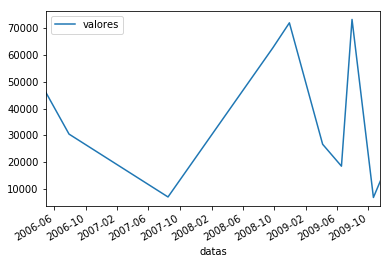

In [318]:
df.plot()
plt.show()

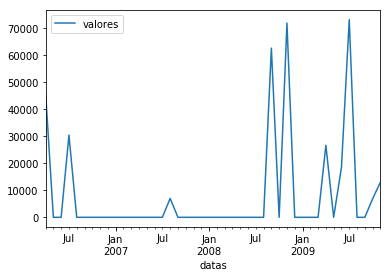

In [317]:
df.resample("M").sum().fillna(0).plot()
plt.show()

In [173]:
rxp = re.findall("(?P<moneys>R\$.*?\s)", teste)
moneys = [el.split("R$")[1].strip() for el in rxp]
list_moneys = []
for money in moneys:
    valor = float(money.replace(",", "").replace(".", "")) / 100
    list_moneys.append(valor)

valor_real = max(list_moneys)
valor_real

60000.0

In [140]:
money_list = []
for el in list_dotacao:
    try:
        valor = float(el.replace(",", "")) * 100
    except:
        valor = float(el.split("\n")[0].replace(",", "")) * 100
        
    money_list.append(valor)

ValueError: could not convert string to float: 'e'

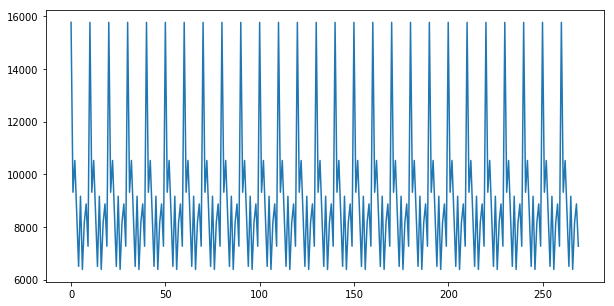

In [133]:
plt.figure(figsize=(10,5))
plt.plot(money_list)
plt.show()

In [33]:
def build_dotacao_dict():
    dotacao_dict = {}
    for key, values in tqdm(process_url_dict.items()):
        for ind, element in enumerate(values):
            resp = requests.get(element)
            if resp.status_code == 200:
                if re.match("16.16.12.365.3010.2825.3.3.50.39.00.00.*", resp.json()["response"]["texto"]):
                    dotacao_dict[key] = resp.json()["response"]["texto"]
                    return dotacao_dict
            else:
                continue

dotacao = build_dotacao_dict()


  1%|          | 5/642 [01:53<3:41:44, 20.89s/it]

KeyboardInterrupt: 

Process ForkPoolWorker-57:
Process ForkPoolWorker-58:
Process ForkPoolWorker-48:
Process ForkPoolWorker-64:
Process ForkPoolWorker-46:
Process ForkPoolWorker-53:
Process ForkPoolWorker-43:
Traceback (most recent call last):
Process ForkPoolWorker-50:
Process ForkPoolWorker-62:
Process ForkPoolWorker-54:
Process ForkPoolWorker-49:
Process ForkPoolWorker-42:
Process ForkPoolWorker-47:
Process ForkPoolWorker-44:
Process ForkPoolWorker-55:
Process ForkPoolWorker-56:
Process ForkPoolWorker-38:
Process ForkPoolWorker-34:
Process ForkPoolWorker-37:
Process ForkPoolWorker-40:
Process ForkPoolWorker-35:
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-41:
Process ForkPoolWorker-52

  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._

  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bartuka/miniconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/bartuka/miniconda3/lib/

In [69]:
def build_dotacao_dict():
    dotacao_dict = {}
    for key, values in tqdm(process_url_dict.items()):
        if len(values) > 0:
            resp = requests.get(values[0])
            if resp.status_code == 200:
                indx = resp.json()["response"]["texto"].find("16.11.12.122.3024.2100.3.3.90.39.00")
                if indx != -1:
                    dotacao_dict[key] = resp.json()["response"]["texto"]
        else:
            continue
    return dotacao_dict

dotacao = build_dotacao_dict()

100%|██████████| 642/642 [03:22<00:00,  3.17it/s]


In [70]:
dotacao

{'2011-0.236.089-5': '((TITULO)) 2011-0.236.089-5\n((TEXTO))   I – No exercício das atribuições legais que me foram delegadas pela Portaria 2.697/SME/GAB/05, AUTORIZO a emissão da  Nota de Empenho no valor de R$ 52,24 (cinquenta e dois reais e vinte e quatro centavos) onerando a dotação 16.11.12.122.3024.2100.3.3.90.39.00. '}

In [319]:
import json

In [330]:
with open("HackInSampa.json") as file:
    _txt = file.read()
    _json = json.loads(_txt)
    json_governo = _json["governo"]
    json_negocios = _json["negocios"]

In [331]:
json_governo

{'01': {'data': '2009-11-17',
  'detalhes': [{'data': '2006-4-28', 'valor': 46200.0},
   {'data': '2006-7-28', 'valor': 30460.0},
   {'data': '2007-8-16', 'valor': 7013.5},
   {'data': '2008-9-26', 'valor': 62664.0},
   {'data': '2008-11-29', 'valor': 71956.8},
   {'data': '2009-4-7', 'valor': 26668.0},
   {'data': '2009-6-19', 'valor': 18497.5},
   {'data': '2009-7-30', 'valor': 73216.0},
   {'data': '2009-10-21', 'valor': 6819.0},
   {'data': '2009-11-17', 'valor': 12984.3}],
  'link_do': 'http://devcolab.each.usp.br/do/2009/11/17/272',
  'orgao': 'GABINETE DO SUBPREFEITO',
  'proporcao_secretaria': 0.35647909999999994,
  'score': 'BAIXO',
  'titulo': 'AUTORIZO',
  'valor': 35647.909999999996}}